# Final project: Brain Tumor MRI Classification Using Different CNN
- #### Subject: Neural Networks
- #### Student: Aiken Kazin, BSc
- #### Teacher: Aigerim Bogyrbayeva, Doctor PhD
- #### University: SDU University, Almaty, Kaskelen
- #### Date: 22.12.2023



# References

- [1] https://doi.org/10.1016/j.compeleceng.2022.108105
- [2] https://ieeexplore.ieee.org/abstract/document/10083818/
- [3] https://www.sciencedirect.com/science/article/pii/S0045790622002361?casa_token=iKDXEz-LTggAAAAA:WmLoTrO60mF81rCdy0eDB7hIWyRi-8zy8MdMPNnZAIRbQP9TPwInszrdTzXfPEgBQv4OclrG

# 1. Importing the necessary libraries

In [1]:
import os

import torch
import torch.nn as nn
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import urllib.request


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"We are using {device} device")

We are using cuda device


# 2. Understanding the Dataset

Link for the paper: https://doi.org/10.1016/j.compeleceng.2022.108105

### The Dataset is called Brain Tumor MRI Dataset taken from Kaggle: 
link for the dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

In [3]:
# Let's count the number of files(images) in Train and Test data

testing_glioma_path = "/kaggle/input/human-brain-mri/human_brain_mri/Testing/glioma"
testing_meningioma_path = "/kaggle/input/human-brain-mri/human_brain_mri/Testing/meningioma"
testing_notumor_path = "/kaggle/input/human-brain-mri/human_brain_mri/Testing/notumor"
testing_pituitary_path = "/kaggle/input/human-brain-mri/human_brain_mri/Testing/pituitary"

training_glioma_path = "/kaggle/input/human-brain-mri/human_brain_mri/Training/glioma"
training_meningioma_path = "/kaggle/input/human-brain-mri/human_brain_mri/Training/meningioma"
training_notumor_path = "/kaggle/input/human-brain-mri/human_brain_mri/Training/notumor"
training_pituitary_path = "/kaggle/input/human-brain-mri/human_brain_mri/Training/pituitary"


path_test = [testing_glioma_path, testing_meningioma_path, testing_notumor_path, testing_pituitary_path]
path_train = [training_glioma_path, training_meningioma_path, training_notumor_path, training_pituitary_path]


testing_files_numbers = {}
training_files_numbers = {}

for path in path_test:
    files = os.listdir(path)
    num_files = len(files)
    testing_files_numbers[path.split('/')[-1]] = num_files

for path in path_train:
    files = os.listdir(path)
    num_files = len(files)
    training_files_numbers[path.split('/')[-1]] = num_files

In [4]:
print("In Training folder we have: ",training_files_numbers)
print("In Testing folder we have: ",testing_files_numbers)

In Training folder we have:  {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
In Testing folder we have:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


### 2.1 About Dataset

The Dataset contains Training and Testing datasets: 
- Training 
  - giloma ($1321$)
  - meningioma ($1339$)
  - notumor ($1595$)
  - pituitary ($1457$)
- Testing 
  - giloma ($300$)
  - meningioma ($306$)
  - notumor ($405$)
  - pituitary ($300$


- #### Classes:
  - Глиома (giloma): 
    - Тип опухоли, происходящей из глиальных клеток мозга, которые обеспечивают поддержку и защиту нейронов.
  - Менингиома (meningioma): 
    - Опухоль, развивающаяся в менингах, слоях ткани, покрывающих мозг и спинной мозг.
  - Без опухоли (notumor): 
    - Указывает на отсутствие выявленной опухоли в мозге.
  - Гипофиз (pituitary): 
    - Относится к опухолям, образующимся в гипофизе - маленькой железе у основания мозга, регулирующей различные функции организма через выделение гормонов.



This dataset contains $7023$ images of human brain MRI images which are classified into $4$ classes: GLIOMA - MENINGIOMA - NO TUMOR- PITUARITY.

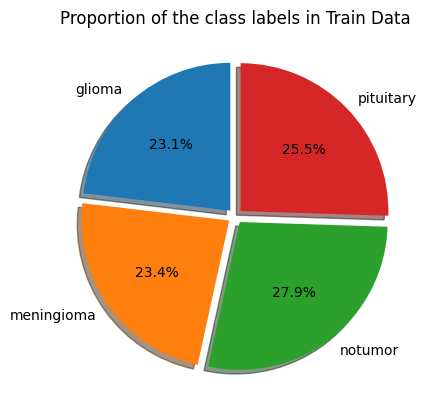

In [5]:
explode = (0.05, 0.05, 0.05, 0.05) 

fig, ax = plt.subplots()
ax.pie(training_files_numbers.values(), explode=explode, labels=training_files_numbers.keys(), autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.title("Proportion of the class labels in Train Data")
plt.show()

Train size:  5712
Test size:  1311


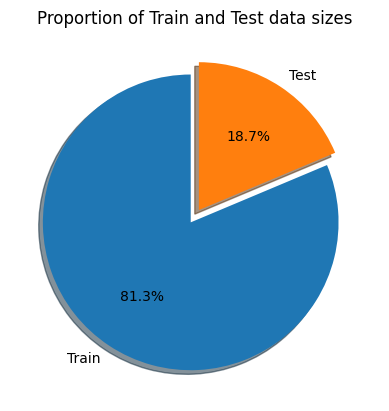

In [6]:
explode = (0.05, 0.05) 
print("Train size: ", sum(training_files_numbers.values()))
print("Test size: ", sum(testing_files_numbers.values()))
fig, ax = plt.subplots()
ax.pie([sum(training_files_numbers.values()), sum(testing_files_numbers.values())], explode=explode, labels=['Train','Test'], autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.title("Proportion of Train and Test data sizes")
plt.show()

We see that from the first pie chart the Train Data is balanced and that is very good :)))))))))

Let's see how our data-image represented

Shape:  (512, 512, 3)


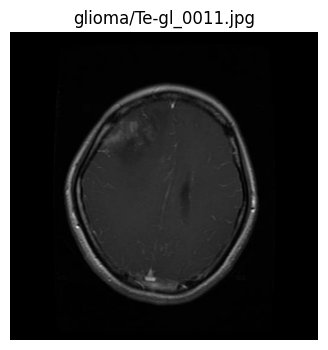

In [7]:
image_path = '/kaggle/input/human-brain-mri/human_brain_mri/Testing/glioma/Te-glTr_0002.jpg'

plt.figure(figsize=(4,4))
img = mpimg.imread(image_path)
print("Shape: ", img.shape)
plt.imshow(img)
plt.axis('off')  # Optional: Turn off axis labels
plt.title("glioma/Te-gl_0011.jpg")
plt.show()

First let's see our images the from different labels

In [8]:
plt.figure(figsize=(8, 8))
# print("A")
for i in range(1, 17):
    if i < 5:
        img = mpimg.imread("human_brain_mri/Training/glioma/Tr-gl_001" + str(i%4) + ".jpg")
        plt.subplot(4, 4, i)
        plt.imshow(img)
        plt.title("glioma")
    elif 5 <= i < 9:
        img = mpimg.imread("human_brain_mri/Training/meningioma/Tr-me_001" + str(i%4) + ".jpg")
        plt.subplot(4, 4, i)
        plt.imshow(img)
        plt.title("meningioma")
    elif 9 <= i < 13:
        img = mpimg.imread("human_brain_mri/Training/notumor/Tr-no_001" + str(i%4) + ".jpg")
        plt.subplot(4, 4, i)
        plt.imshow(img)
        plt.title("notumor")
    elif 13 <= i < 17:
        img = mpimg.imread("human_brain_mri/Training/pituitary/Tr-pi_001" + str(i%4) + ".jpg")
        plt.subplot(4, 4, i)
        plt.imshow(img)
        plt.title("pituitary")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'human_brain_mri/Training/glioma/Tr-gl_0011.jpg'

<Figure size 800x800 with 0 Axes>

https://www.kaggle.com/code/riddhich/brain-tumor-classification

# 3. Data preprocessing and augmentation

https://www.kaggle.com/code/abdallahwagih/brain-tumor-classification-pytorch

In [22]:
# Get the list of all files in the folder

folder_path = 'human_brain_mri/Training'

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
shapes_of_images = set()
shapes_of_images_list = []

# count the shape of all files/images
for label in class_labels:
    files = os.listdir(folder_path + "/" + label)
    for file in files:
        img = mpimg.imread(folder_path + "/" + label  + "/" + file)
        shapes_of_images.add(img.shape)
        shapes_of_images_list.append(img.shape)

print("We have " + str(len(shapes_of_images)) + " different shapes")

# Lets see them
print(shapes_of_images)

We have 395 different shapes

{(395, 367, 3), (290, 236, 3), (717, 717, 3), (302, 216, 3), (245, 206, 3), (512, 434, 3), (250, 201, 3), (274, 230, 3), (442, 442, 3), (228, 233, 3), (480, 853, 3), (484, 405, 3), (248, 208, 3), (417, 428, 3), (344, 320, 3), (273, 236, 3), (236, 236, 3), (244, 206, 3), (470, 469, 3), (214, 229, 3), (496, 453, 3), (216, 234, 3), (439, 645, 3), (395, 416, 3), (236, 255, 3), (342, 323, 3), (257, 235, 3), (1080, 1920, 3), (340, 507, 3), (222, 233, 3), (486, 421, 3), (260, 314, 3), (512, 416, 3), (270, 250, 3), (415, 339, 3), (301, 275, 3), (243, 207, 3), (903, 721, 3), (300, 227, 3), (372, 341, 3), (592, 562, 3), (282, 230, 3), (225, 209, 3), (306, 278, 3), (361, 642, 3), (225, 225), (355, 330, 3), (228, 236, 3), (872, 850, 3), (213, 210, 3), (223, 224, 3), (248, 200, 3), (218, 234, 3), (320, 497, 3), (320, 257, 3), (365, 306, 3), (248, 257, 3), (442, 442), (613, 605, 3), (239, 236, 3), (354, 298, 3), (258, 300, 3), (280, 236, 3), (400, 393, 4), (201, 173, 3)

In the list above, we see that some images has 3 color channel, some images has 4 channel and some of them doesnt have a channel(gray scale image). So, we need some Pre-Processing

In [9]:
data_transforms = transforms.Compose([
    transforms.Resize((324, 324)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder('/kaggle/input/human-brain-mri/human_brain_mri/Training', transform=data_transforms)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

test_data = ImageFolder('/kaggle/input/human-brain-mri/human_brain_mri/Testing', transform=data_transforms)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /kaggle/input/human-brain-mri/human_brain_mri/Training
    StandardTransform
Transform: Compose(
               Resize(size=(324, 324), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [25]:
s = 0
d = 0
for i in train_data:
    s+=1
    if i[0].shape[0] == 3:
        d+=1
print(s)
print(d)
print(i[0].shape, i[1])

5712

5712

torch.Size([3, 324, 324]) 3


We see that all data samples has 3 channels.

Let's see how our transformed matrix looks

In [26]:
for X in train_loader:
    print("shape: ",X[0].shape, "label: ", print(X[1]))
    print(X)
    break

tensor([3, 3, 2, 2, 2, 2, 0, 1, 0, 1, 2, 2, 3, 1, 1, 1])

shape:  torch.Size([16, 3, 324, 324]) label:  None

[tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          ...,

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],



         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          ...,

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357

In [242]:
# img_array = np.array(X[0][0])
# print(img_array.shape)
# plt.imshow(img_array.transpose(1,2,0))
# plt.show()

# 4. Define Deep Learning Models

#### In this project I am going to use the following Neural Net architectures

- AlexNet
- LeNet
- VGG
- ResNet  (says advanced)
- Inception (says advanced)
- DenseNe (says advanced)

## 4.1. Building AlexNet

https://www.kaggle.com/code/maryanalyze/alexnet-pytorch-from-scratch-transfer-learning

The paper for AlexNet: https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

In [10]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),

            torch.nn.Conv2d(96, 256, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),

            torch.nn.Conv2d(256, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(),

            torch.nn.Conv2d(384, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        return logits

## 4.2. Building LeNet

In [15]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(97344 ,120),  #in_features = 16 x5x5 
            nn.ReLU(),
            nn.Linear(120,84),
            nn.ReLU(),
            nn.Linear(84,4),    # we have 4 class for Brain Tumor
            nn.Softmax()
        )
        
    def forward(self,x): 
        x=self.feature_extractor(x)
        x = torch.flatten(x,1)
        x=self.classifier(x)
        return x

In [24]:
alexnet_model = AlexNet()
alexnet_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=F

In [17]:
lenet_model = LeNet()
lenet_model.to(device)

LeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=97344, out_features=120, bias=True)
    (1): ReLU()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): ReLU()
    (4): Linear(in_features=84, out_features=4, bias=True)
    (5): Softmax(dim=None)
  )
)

## 4.2. Loss Function and OPtimizer

In [25]:
criterion_alexnet = nn.CrossEntropyLoss()
optim_alexnet = torch.optim.SGD(alexnet_model.parameters(),lr = 0.01,)

In [18]:
criterion_lenet = nn.CrossEntropyLoss()
optim_lenet = torch.optim.SGD(lenet_model.parameters(), lr = 0.001,)

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    correct_train = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct_train += (pred.argmax(1) == y).sum().item()

        if batch % 100 == 0:
            current = batch * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    # Calculate training accuracy for the epoch
    train_accuracy = correct_train / size
    train_loss /= len(dataloader)

    return train_loss, train_accuracy

In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    correct = 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).sum().item()

    # Calculate test accuracy for the epoch
    test_loss /= num_batches
    test_accuracy = correct / size

    print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, test_accuracy

Train for AlexNet

In [26]:
epochs = 16
train_losses_alex = []
train_accuracies_alex = []
test_losses_alex = []
test_accuracies_alex = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(train_loader, alexnet_model, criterion_alexnet, optim_alexnet)
    test_loss, test_accuracy = test(test_loader, alexnet_model, criterion_alexnet)

    # Store the results for visualization
    train_losses_alex.append(train_loss)
    train_accuracies_alex.append(train_accuracy)
    test_losses_alex.append(test_loss)
    test_accuracies_alex.append(test_accuracy)

print("Done!")

Epoch 1
-------------------------------
loss: 1.385454  [    0/ 5712]
loss: 1.391863  [ 1600/ 5712]
loss: 1.306879  [ 3200/ 5712]
loss: 1.012827  [ 4800/ 5712]
Test Error: 
 Accuracy: 47.7%, Avg loss: 1.151426 

Epoch 2
-------------------------------
loss: 1.021763  [    0/ 5712]
loss: 1.220068  [ 1600/ 5712]
loss: 1.412158  [ 3200/ 5712]
loss: 0.954613  [ 4800/ 5712]
Test Error: 
 Accuracy: 58.6%, Avg loss: 1.115096 

Epoch 3
-------------------------------
loss: 0.987707  [    0/ 5712]
loss: 1.024826  [ 1600/ 5712]
loss: 0.863055  [ 3200/ 5712]
loss: 0.808290  [ 4800/ 5712]
Test Error: 
 Accuracy: 67.2%, Avg loss: 0.854566 

Epoch 4
-------------------------------
loss: 0.680302  [    0/ 5712]
loss: 0.761417  [ 1600/ 5712]
loss: 0.407418  [ 3200/ 5712]
loss: 0.951178  [ 4800/ 5712]
Test Error: 
 Accuracy: 67.9%, Avg loss: 0.743569 

Epoch 5
-------------------------------
loss: 0.619317  [    0/ 5712]
loss: 0.996546  [ 1600/ 5712]
loss: 1.017043  [ 3200/ 5712]
loss: 0.649649  [ 4800

############ AlexNet ###########


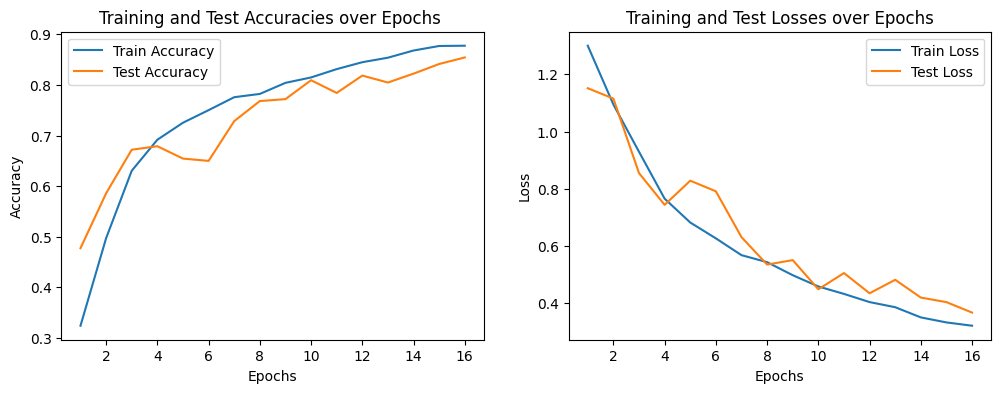

In [29]:

plt.figure(figsize=(12, 4))
print("############ AlexNet ###########")
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies_alex, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_alex, label='Test Accuracy')
plt.title('Training and Test Accuracies over Epochs ')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses_alex, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses_alex, label='Test Loss')
plt.title('Training and Test Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

##### Train for LeNet

In [20]:
epochs = 16
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss, train_accuracy = train(train_loader, lenet_model, criterion_lenet, optim_lenet)
    test_loss, test_accuracy = test(test_loader, lenet_model, criterion_lenet)

    # Store the results for visualization
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

print("Done!")

Epoch 1
-------------------------------


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


loss: 1.389701  [    0/ 5712]
loss: 1.381312  [ 1600/ 5712]
loss: 1.378655  [ 3200/ 5712]
loss: 1.373134  [ 4800/ 5712]
Test Error: 
 Accuracy: 58.7%, Avg loss: 1.376444 

Epoch 2
-------------------------------
loss: 1.370548  [    0/ 5712]
loss: 1.370470  [ 1600/ 5712]
loss: 1.378889  [ 3200/ 5712]
loss: 1.321008  [ 4800/ 5712]
Test Error: 
 Accuracy: 59.3%, Avg loss: 1.339463 

Epoch 3
-------------------------------
loss: 1.361787  [    0/ 5712]
loss: 1.343489  [ 1600/ 5712]
loss: 1.237652  [ 3200/ 5712]
loss: 1.159340  [ 4800/ 5712]
Test Error: 
 Accuracy: 60.4%, Avg loss: 1.152196 

Epoch 4
-------------------------------
loss: 1.230875  [    0/ 5712]
loss: 1.120408  [ 1600/ 5712]
loss: 1.041616  [ 3200/ 5712]
loss: 1.098407  [ 4800/ 5712]
Test Error: 
 Accuracy: 64.1%, Avg loss: 1.097791 

Epoch 5
-------------------------------
loss: 0.933500  [    0/ 5712]
loss: 0.943522  [ 1600/ 5712]
loss: 1.099607  [ 3200/ 5712]
loss: 1.046535  [ 4800/ 5712]
Test Error: 
 Accuracy: 62.6%, A

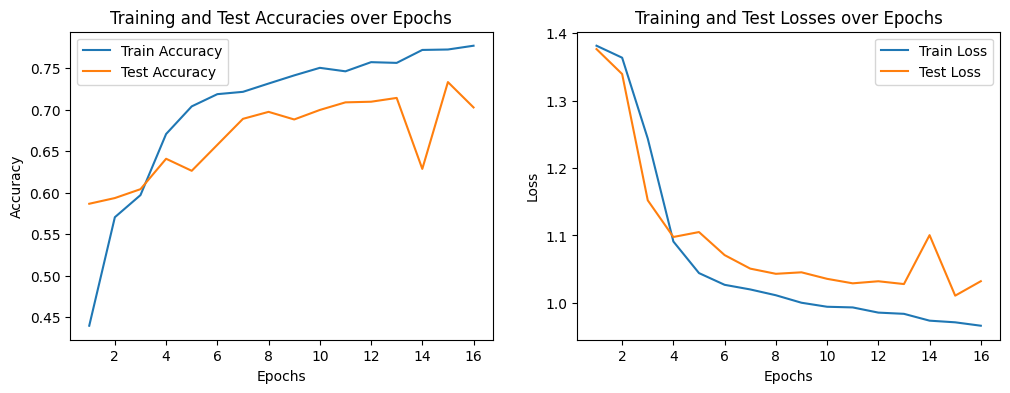

In [21]:
# Visualize the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracies over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
plt.title('Training and Test Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [274]:
for batch, (X, y) in enumerate(train_loader):
    print(batch)
    print()
    print()
    print(X)
    print()
    print()
    print(y)
    break

0





tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          ...,

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],

          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],



         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          ...,

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],

          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],



         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],

      